In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier

from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

import xgboost as xgb

from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations

import umap

In [3]:
file_name = 'Uzorak iz baze podataka o telekom korisnicima.xlsx'
sheet_name = 'Baza podataka'

df_loaded = pd.read_excel(file_name, sheet_name=sheet_name, index_col=0)

In [50]:
df_loaded.head()

,Broj usluga,Iznos računa,Prosječni iznos računa,Tržišna cijena,Tržišna cijena - ezoterija,POTS,ADSL,IPTV,PoP,Imaju POTS,...,TARIFA 62,TARIFA 63,TARIFA 64,TARIFA 65,TARIFA 66,TARIFA 67,TARIFA 68,TARIFA 69,TARIFA 70,TARIFA 71
ID,,,,,,,,,,,,,,,,,,,,,
1066143,14,37.50,2.68,5.016986,5.299552,6,6,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1066037,8,61.78,7.72,5.016986,7.647124,5,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1065734,4,34.01,8.50,5.016986,5.979493,1,1,1,1,1,...,0,3,0,0,0,0,0,0,0,0
1052934,4,23.91,5.98,5.016986,5.323251,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1068401,2,10.00,5.00,5.016986,7.071068,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print('Shape:', df_loaded.shape)

Shape: (60000, 167)


In [9]:
random_rows = df_loaded.sample(n=100)

# Save the random sample to an Excel file
random_rows.to_excel('Database sample.xlsx', index=False)

# DATA PREPARATION

In [4]:
df_cleaned = df_loaded.copy()

In [5]:
corr_matrix = df_cleaned.corr()

# Create a DataFrame to store the pairs of highly correlated columns
high_corr_pairs = []

# Iterate over the correlation matrix to find pairs with correlation > 0.8
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr_pairs.append((colname1, colname2, corr_matrix.iloc[i, j]))

# Print the highly correlated column pairs
print("Highly correlated column pairs with correlation > 0.8:")
for pair in high_corr_pairs:
    print(f"Columns: {pair[0]} and {pair[1]} - Correlation: {pair[2]:.2f}")

Highly correlated column pairs with correlation > 0.8:
Columns: POTS and Broj usluga - Correlation: 0.88
Columns: ADSL and Broj usluga - Correlation: 0.89
Columns: ADSL and POTS - Correlation: 0.86
Columns: IPTV and Broj usluga - Correlation: 0.83
Columns: Imaju POTS and Broj usluga - Correlation: 0.86
Columns: Imaju POTS and POTS - Correlation: 0.97
Columns: Imaju POTS and ADSL - Correlation: 0.85
Columns: Imaju ADSL and Broj usluga - Correlation: 0.87
Columns: Imaju ADSL and POTS - Correlation: 0.84
Columns: Imaju ADSL and ADSL - Correlation: 0.98
Columns: Imaju ADSL and Imaju POTS - Correlation: 0.86
Columns: Imaju IPTV and Broj usluga - Correlation: 0.82
Columns: Imaju IPTV and IPTV - Correlation: 0.99
Columns: Promet INT and Potrošnja INT - Correlation: 0.98
Columns: Ukupni pozivi and Ukupni promet - Correlation: 0.86
Columns: Pozivi OnNet MOB and Promet OnNet MOB - Correlation: 0.90
Columns: Pozivi OnNet MOB and Ukupni pozivi - Correlation: 0.82
Columns: Pozivi OffNet MOB and Pro

Let's check for constant features and remove them.

In [6]:
constant_features = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 1]

print("Constant Features:", constant_features)

df_cleaned.drop(columns=constant_features, inplace=True)

Constant Features: ['Imaju PoP']


In [15]:
df_cleaned.shape

(60000, 166)

# CLUSTERING

## GAUSSIAN MIXTURE MODEL (GMM)

In [51]:
df_full = df_cleaned.copy()
df_full.columns

Index(['Broj usluga', 'Iznos računa', 'Prosječni iznos računa',
       'Tržišna cijena', 'Tržišna cijena - ezoterija', 'POTS', 'ADSL', 'IPTV',
       'PoP', 'Imaju POTS',
       ...
       'TARIFA 62', 'TARIFA 63', 'TARIFA 64', 'TARIFA 65', 'TARIFA 66',
       'TARIFA 67', 'TARIFA 68', 'TARIFA 69', 'TARIFA 70', 'TARIFA 71'],
      dtype='object', length=166)

In [8]:
# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_full)

# Step 2: Perform PCA
pca = PCA(n_components=0.8, svd_solver='full')
df_pca = pca.fit_transform(df_scaled)

# Convert the PCA result back to a dataframe
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

df_pca.index = df_full.index

In [11]:
df_pca.shape

(60000, 90)

In [10]:
# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance Ratio by each component:")
print(pca.explained_variance_ratio_ * 100)

Explained Variance Ratio by each component:
[6.87395092 4.02715788 2.36149346 2.11590998 1.77674627 1.68055535
 1.57942217 1.4640205  1.44091765 1.33293766 1.20375716 1.19569376
 1.13628762 1.08831276 1.01438775 0.99896859 0.95345714 0.94761909
 0.89321481 0.88955382 0.85579389 0.810556   0.79056939 0.77813474
 0.76312928 0.75316634 0.74406577 0.73595201 0.72806906 0.71819
 0.70989373 0.70538151 0.70119393 0.69530876 0.69326077 0.68896681
 0.68209142 0.67606229 0.67335131 0.66647549 0.66410698 0.65815372
 0.65436383 0.65053863 0.64691662 0.64258603 0.64172425 0.64069729
 0.63917428 0.63417437 0.63305858 0.63060449 0.62941631 0.62516685
 0.62378967 0.62218179 0.62112534 0.61816595 0.61763542 0.61635641
 0.61427614 0.6136891  0.61263258 0.61099609 0.61085159 0.60948074
 0.60903346 0.60791956 0.60677696 0.60480429 0.60377726 0.60279229
 0.60219817 0.60204582 0.60112099 0.60021028 0.59921361 0.59816859
 0.5974877  0.5965029  0.59502975 0.59347701 0.59237012 0.59115504
 0.58902225 0.5885693

In [11]:
print("\nCumulative Variance Explained:")
print(cumulative_variance * 100)


Cumulative Variance Explained:
[ 6.87395092 10.90110881 13.26260227 15.37851225 17.15525852 18.83581387
 20.41523604 21.87925655 23.32017419 24.65311186 25.85686902 27.05256278
 28.1888504  29.27716316 30.29155091 31.2905195  32.24397664 33.19159574
 34.08481055 34.97436438 35.83015827 36.64071427 37.43128366 38.2094184
 38.97254768 39.72571402 40.46977979 41.2057318  41.93380086 42.65199086
 43.36188459 44.06726611 44.76846004 45.4637688  46.15702957 46.84599638
 47.5280878  48.20415009 48.8775014  49.54397689 50.20808386 50.86623759
 51.52060142 52.17114006 52.81805668 53.46064271 54.10236696 54.74306425
 55.38223853 56.0164129  56.64947149 57.28007598 57.90949228 58.53465913
 59.1584488  59.78063059 60.40175594 61.01992189 61.63755731 62.25391372
 62.86818986 63.48187896 64.09451154 64.70550763 65.31635923 65.92583997
 66.53487343 67.14279299 67.74956994 68.35437423 68.95815148 69.56094377
 70.16314194 70.76518776 71.36630875 71.96651903 72.56573264 73.16390123
 73.76138893 74.3578

In [105]:
# Determine the Optimal Number of Clusters (K)
bic_scores = []
aic_scores = []
n_components_range = range(1, 16)  # Testing for K=1 to K=10

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=53)
    gmm.fit(df_pca)
    bic_scores.append(gmm.bic(df_pca))
    aic_scores.append(gmm.aic(df_pca))


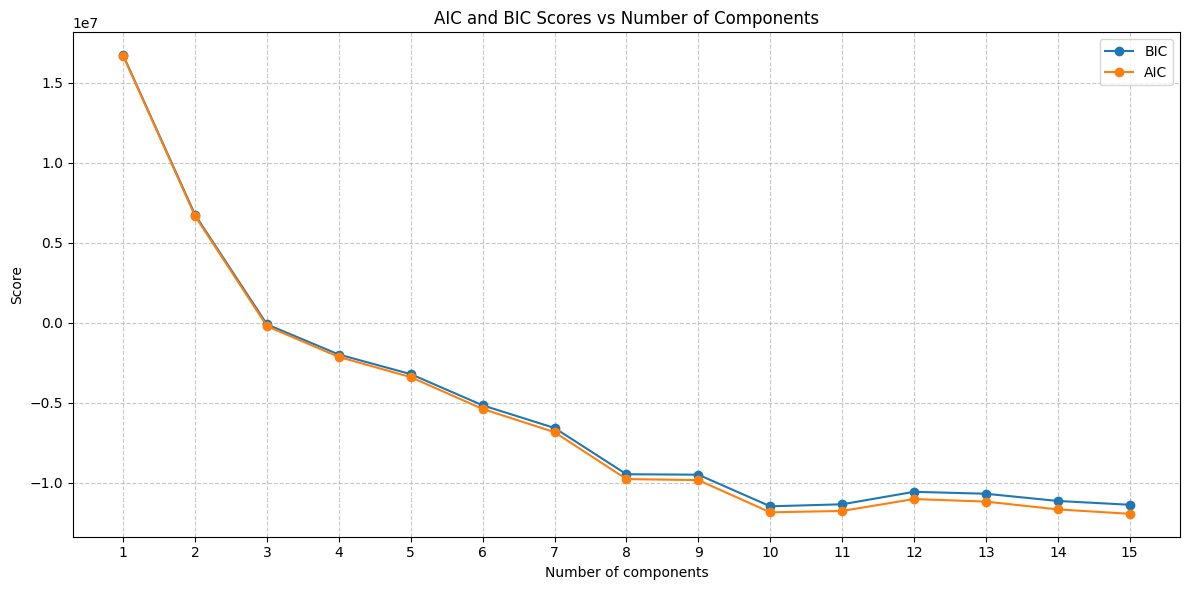

In [106]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')

# Add labels and title
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores vs Number of Components')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)


# Set x-ticks to whole numbers
plt.xticks(np.arange(min(n_components_range), max(n_components_range)+1, 1))

# Update legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

With this graph it's much easier to decide optimal number of components visually by using elbow method and it is 8.

In [55]:
gmm_optimal = GaussianMixture(n_components=8, random_state=53)
df_full['Segment'] = gmm_optimal.fit_predict(df_pca)

df_full['Segment'].value_counts()

5    21525
0    14498
2     8845
3     5325
1     4859
6     2033
4     1925
7      990
Name: Segment, dtype: int64

## VISUALIZATION

### UMAP

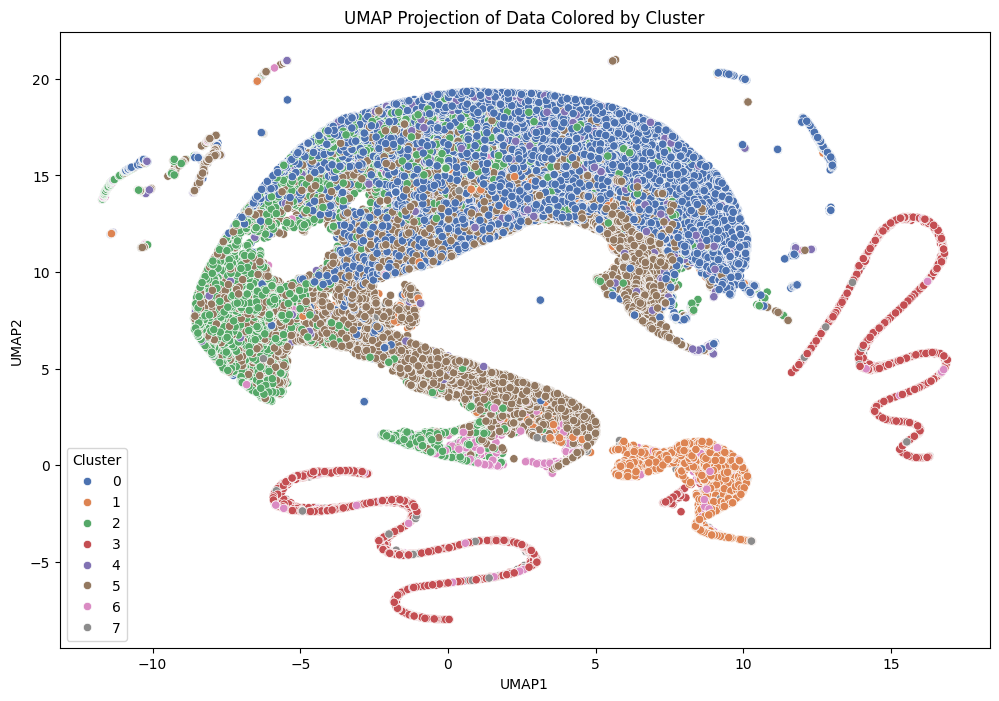

In [23]:
# Assuming df_full is your DataFrame
# If not, load your data into df_full

# Separate the features and the cluster labels
features = df_full.iloc[:, :-1]  # All columns except the last one
cluster_labels = df_full.iloc[:, -1]  # Last column

# Create and fit the UMAP model
umap_model = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='euclidean')
umap_result = umap_model.fit_transform(features)

# Create a new DataFrame with UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = cluster_labels.values  # Ensure we're adding the values, not the Series

# Convert 'Cluster' to categorical type if it's not already
umap_df['Cluster'] = umap_df['Cluster'].astype('category')

# Plot the results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Cluster', palette='deep')
plt.title('UMAP Projection of Data Colored by Cluster')
plt.show()

/var/folders/nl/w1k6kw552t5cyl185c6p43y80000gn/T/ipykernel_2127/2761430710.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(umap_df['Cluster'].unique())))


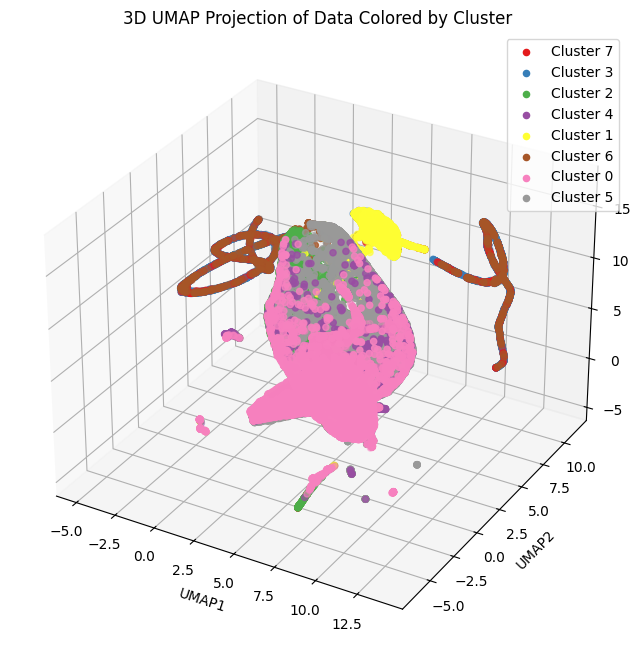

In [18]:
# Assuming df_full is your DataFrame
# If not, load your data into df_full

# Separate the features and the cluster labels
features = df_full.iloc[:, :-1]  # All columns except the last one
cluster_labels = df_full.iloc[:, -1]  # Last column

# Create and fit the UMAP model (now with 3 components)
umap_model = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.1, metric='euclidean')
umap_result = umap_model.fit_transform(features)

# Create a new DataFrame with UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['Cluster'] = cluster_labels.values  # Ensure we're adding the values, not the Series

# Convert 'Cluster' to categorical type if it's not already
umap_df['Cluster'] = umap_df['Cluster'].astype('category')

# Plot the results in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a color map
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(umap_df['Cluster'].unique())))

for cluster, color in zip(umap_df['Cluster'].unique(), colors):
    cluster_data = umap_df[umap_df['Cluster'] == cluster]
    ax.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], cluster_data['UMAP3'], 
               c=[color], label=f'Cluster {cluster}')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.legend()
plt.title('3D UMAP Projection of Data Colored by Cluster')
plt.show()

### PCA

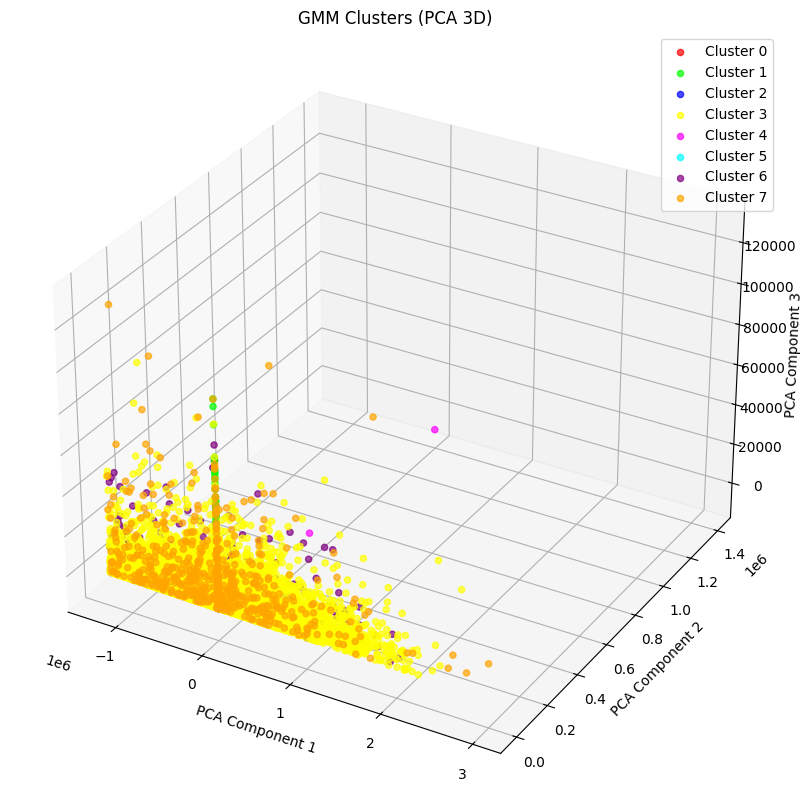

In [17]:
# 1. PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_full.drop(columns=['Segment']))

# Define a list of 8 distinct colors
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800080', '#FFA500'] 

# Create a function to plot the results in 3D
def plot_clusters_3d(data, labels, title):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a color map
    color_map = {i: colors[i] for i in range(8)}
    
    # Plot each cluster
    for cluster in range(8):
        cluster_data = data[labels == cluster]
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], 
                   c=[color_map[cluster]], label=f'Cluster {cluster}', alpha=0.7)
    
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()

# Plot the results
plot_clusters_3d(pca_result, df_full['Segment'], 'GMM Clusters (PCA 3D)')

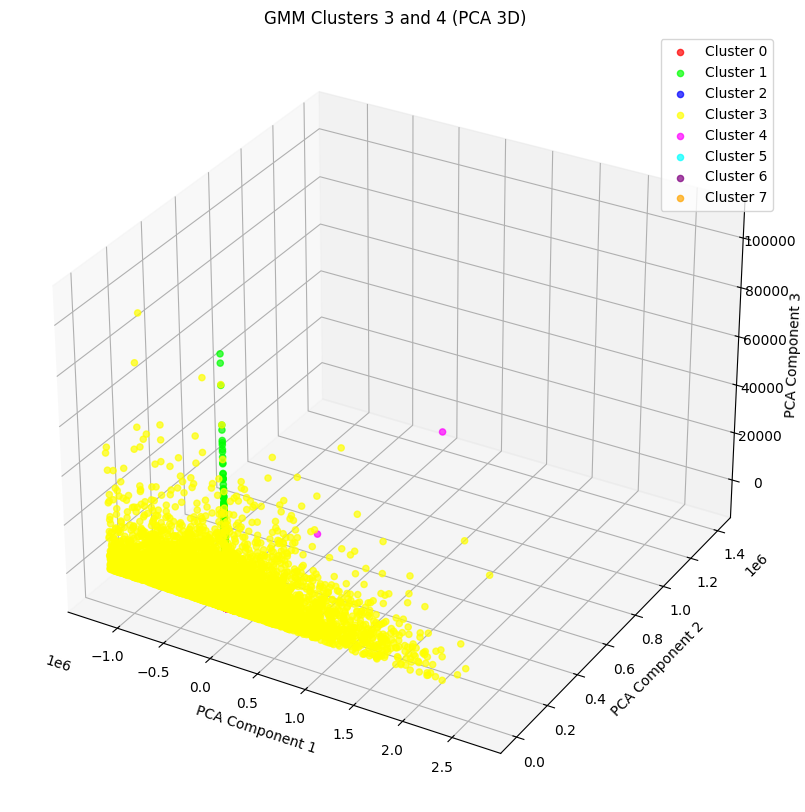

In [122]:
df_filtered = df_full[df_full['Segment'].isin([0, 1, 3, 4])]
pca_result_filtered = pca_result[df_full['Segment'].isin([0, 1, 3, 4])]

# Plot the results for clusters 3 and 4
plot_clusters_3d(pca_result_filtered, df_filtered['Segment'], 'GMM Clusters 3 and 4 (PCA 3D)')

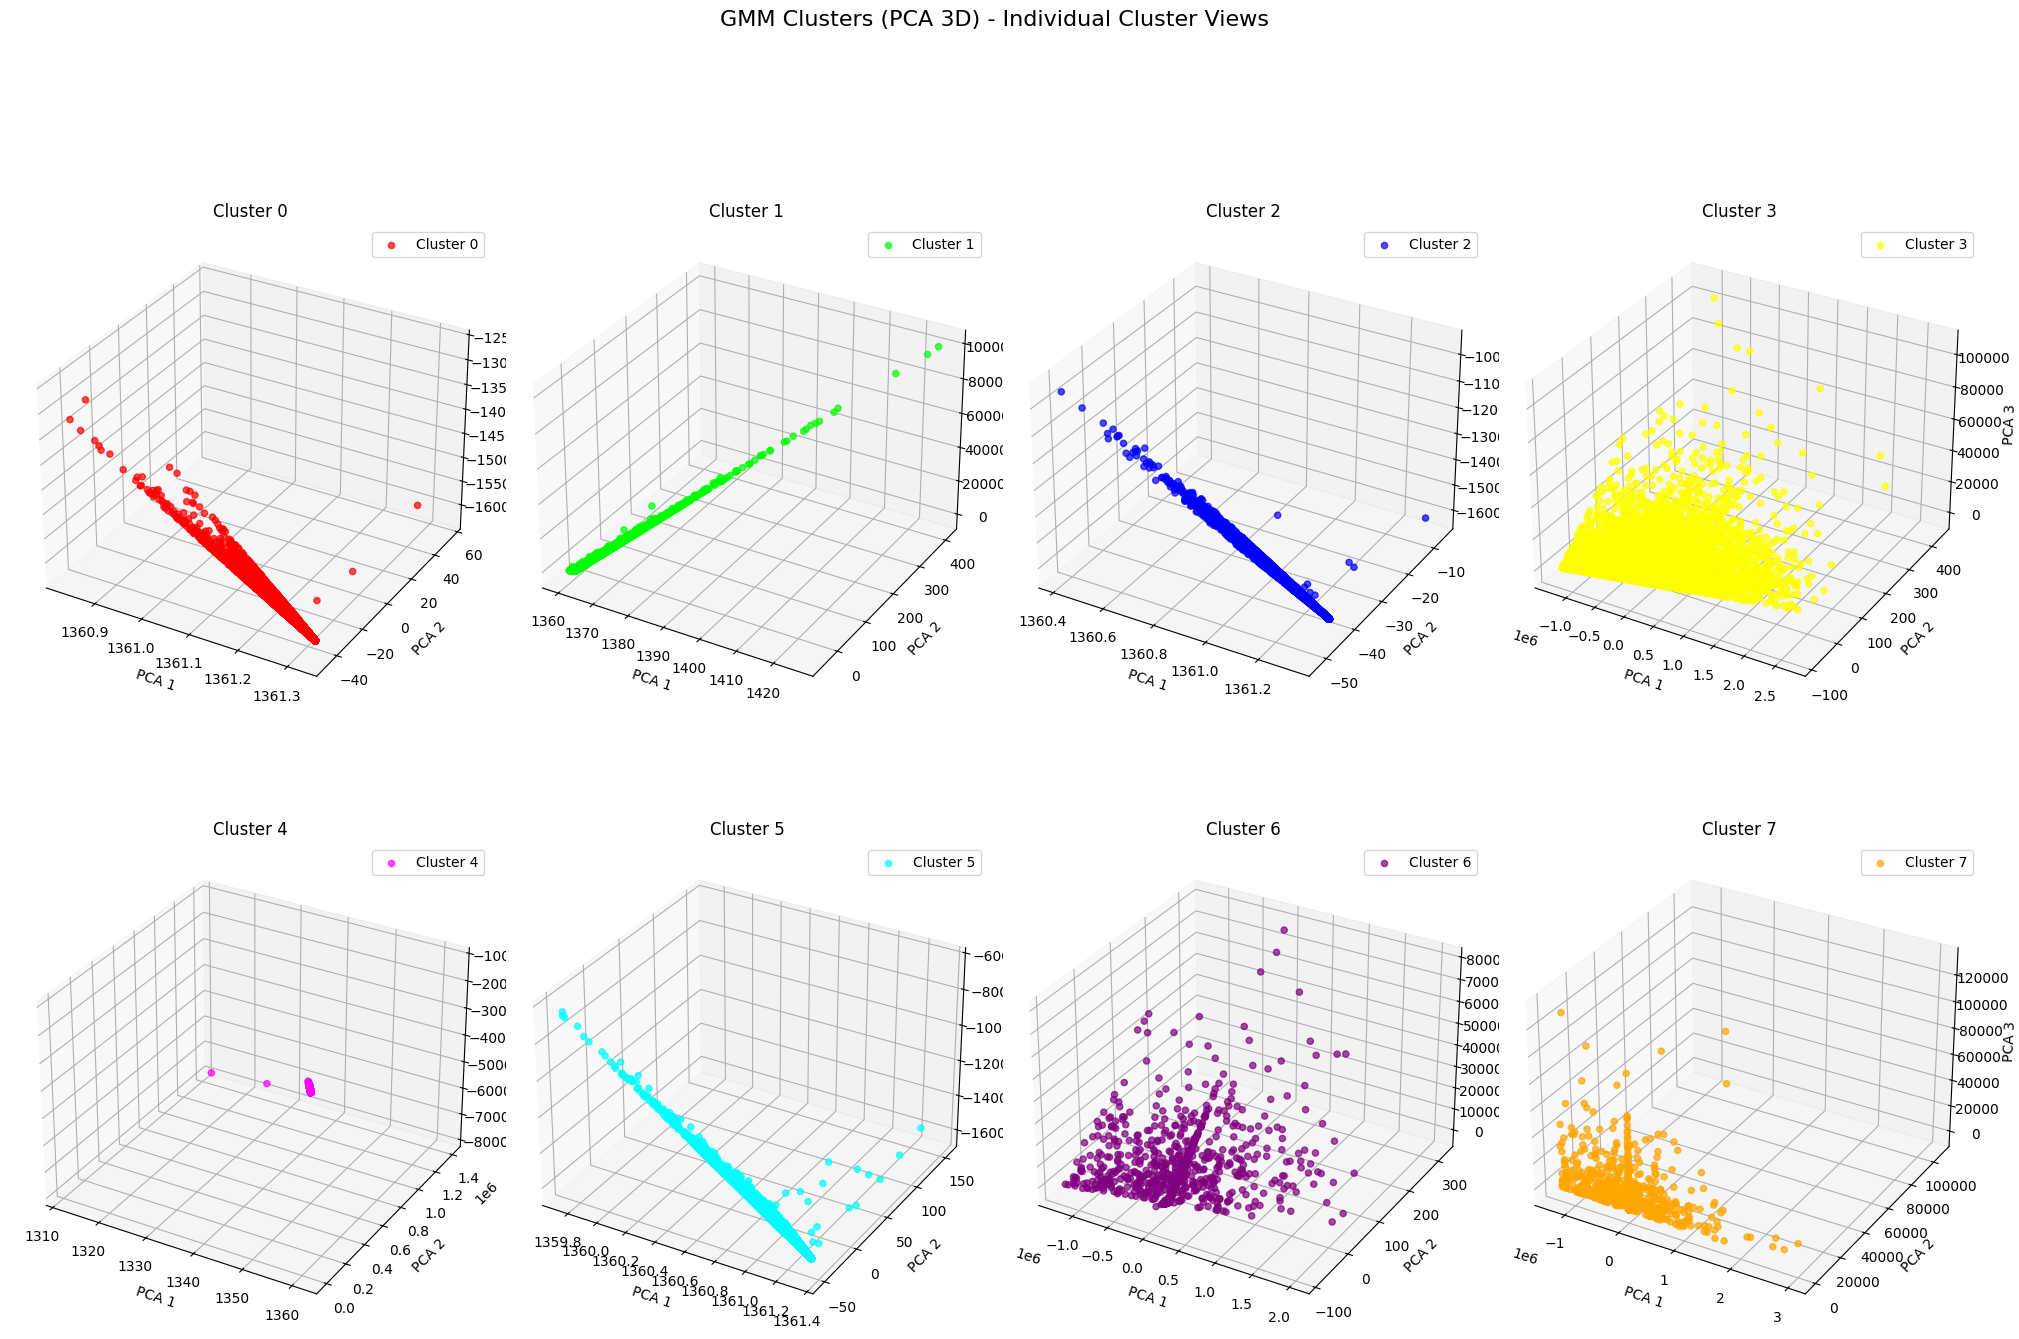

In [18]:
# Define a list of 8 distinct colors
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800080', '#FFA500']

# Create a function to plot individual clusters in 3D
def plot_single_cluster_3d(ax, data, cluster_num, color):
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, label=f'Cluster {cluster_num}', alpha=0.7)
    ax.set_title(f'Cluster {cluster_num}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    ax.legend()

# Create subplots
fig = plt.figure(figsize=(20, 15))
fig.suptitle('GMM Clusters (PCA 3D) - Individual Cluster Views', fontsize=16)

for cluster in range(8):
    ax = fig.add_subplot(2, 4, cluster+1, projection='3d')
    cluster_data = pca_result[df_full['Segment'] == cluster]
    plot_single_cluster_3d(ax, cluster_data, cluster, colors[cluster])

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust the top spacing to accommodate the main title
plt.show()

In [65]:
df_full['Segment'].value_counts().sort_index()

Cluster_GMM
0    14498
1     4859
2     8845
3     5325
4     1925
5    21525
6     2033
7      990
Name: count, dtype: int64

### STABILITY ANALYSIS
I will use different random states to see if cluster sizes are similar.

In [10]:
for rs in [1, 2]:
    gmm_optimal = GaussianMixture(n_components=8, random_state=rs)
    df_full['Cluster_GMM_rand'] = gmm_optimal.fit_predict(df_pca)

    print(df_full['Cluster_GMM_rand'].value_counts())

df_full.drop(columns=['Cluster_GMM_rand'], inplace=True)

Cluster_GMM_rand
0    19207
6    14510
5    12002
3     4996
7     3539
4     2326
1     2221
2     1199
Name: count, dtype: int64
Cluster_GMM_rand
0    22630
4    15106
3     9386
7     6697
5     2553
1     2447
2     1072
6      109
Name: count, dtype: int64


Cluster sizes are relatively similar.

# SEGMENT DESCRIPTION (FEATURE IMPORTANCE)

In [10]:
# Function to calculate mean and std dev for a feature in a specific cluster
def get_mean_std(feature, cluster_num, dataframe):
    cluster_data = dataframe[dataframe['Segment'] == cluster_num][feature]
    return cluster_data.mean(), cluster_data.std()

# Function to calculate mean for a feature across the entire dataset
def get_overall_mean(feature, dataframe):
    return dataframe[feature].mean()

## VARIANCE ANALYSIS

In [11]:
def cluster_feature_tests(df, cluster_column='Segment', mean_diff_threshold=0.05):
    features = [col for col in df.columns if col != cluster_column]
    clusters = sorted(df[cluster_column].unique())
    results = []
    
    # Calculate total number of tests for Bonferroni correction
    n_tests = len(features) * len(list(combinations(clusters, 2)))
    bonferroni_threshold = 0.05 / n_tests
    
    print(f"Bonferroni corrected p-value threshold: {bonferroni_threshold:.6f}")
    
    for (cluster1, cluster2) in combinations(clusters, 2):
        for feature in features:
            cluster1_data = df[df[cluster_column] == cluster1][feature]
            cluster2_data = df[df[cluster_column] == cluster2][feature]
            
            # Determine if the feature is binary
            is_binary = set(df[feature].unique()) == {0, 1}
            
            if is_binary:
                # Perform chi-squared test for binary variables
                contingency_table = pd.crosstab(df[cluster_column].isin([cluster1, cluster2]), df[feature])
                chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
                test_statistic = chi2
                effect_size = np.sqrt(chi2 / (len(cluster1_data) + len(cluster2_data)))  # Cramer's V
                test_type = "Chi-squared"
            else:
                # Perform t-test for continuous variables
                if cluster1_data.nunique() == 1 or cluster2_data.nunique() == 1:
                    test_statistic, p_value, effect_size = np.nan, np.nan, np.nan
                else:
                    try:
                        test_statistic, p_value = stats.ttest_ind(cluster1_data, cluster2_data)
                        # Calculate Cohen's d
                        n1, n2 = len(cluster1_data), len(cluster2_data)
                        s1, s2 = np.var(cluster1_data, ddof=1), np.var(cluster2_data, ddof=1)
                        s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
                        effect_size = (np.mean(cluster1_data) - np.mean(cluster2_data)) / s
                    except:
                        test_statistic, p_value, effect_size = np.nan, np.nan, np.nan
                test_type = "T-test"
            
            # Calculate mean and standard deviation for both clusters
            cluster1_mean, cluster1_std = cluster1_data.mean(), cluster1_data.std()
            cluster2_mean, cluster2_std = cluster2_data.mean(), cluster2_data.std()
            
            # Calculate overall mean for the feature
            feature_mean = df[feature].mean()
            
            # Check if the means differ by the specified threshold
            if cluster1_mean == cluster2_mean == 0:
                mean_diff = 0
                mean_diff_significant = False
            else:
                denominator = max(abs(cluster1_mean), abs(cluster2_mean))
                if denominator == 0:
                    mean_diff = 1 if cluster1_mean != cluster2_mean else 0
                else:
                    mean_diff = abs(cluster1_mean - cluster2_mean) / denominator
                mean_diff_significant = mean_diff > mean_diff_threshold
            
            # Consider as significant if p-value is less than Bonferroni threshold or means differ significantly
            significant = (not np.isnan(p_value) and p_value < bonferroni_threshold) or mean_diff_significant
            
            results.append({
                'Cluster pair': f'Clusters {cluster1} and {cluster2}',
                'Feature': feature,
                'Test Type': test_type,
                'Test Statistic': round(test_statistic, 6) if not np.isnan(test_statistic) else np.nan,
                'p-value': round(p_value, 6) if not np.isnan(p_value) else np.nan,
                'Effect Size': round(effect_size, 6) if not np.isnan(effect_size) else np.nan,
                'Mean (first cluster)': round(cluster1_mean, 6),
                'Std Dev (first cluster)': round(cluster1_std, 6),
                'Mean (second cluster)': round(cluster2_mean, 6),
                'Std Dev (second cluster)': round(cluster2_std, 6),
                'Feature Mean': round(feature_mean, 6),
                'Mean Difference (%)': round(mean_diff * 100, 2),
                'Significant': significant
            })
    
    test_results_df = pd.DataFrame(results)
    
    # Sort the DataFrame
    test_results_df = test_results_df.sort_values(
        ['Cluster pair', 'p-value'], 
        na_position='last'
    )
    
    return test_results_df

In [12]:
test_results = cluster_feature_tests(df_full)

Bonferroni corrected p-value threshold: 0.000011


In [13]:
# Create a new DataFrame for significant features
significant_features = []

for _, row in test_results.iterrows():
    if row['Significant']:
        cluster_pair = row['Cluster pair']
        feature = row['Feature']
        clusters = cluster_pair.split(' and ')
        
        for cluster in clusters:
            cluster_num = cluster.split()[-1]  # Extract the cluster number
            significant_features.append({
                'Cluster': f'Cluster {cluster_num}',
                'Feature': feature
            })

# Remove duplicates
significant_features_df = pd.DataFrame(significant_features).drop_duplicates()

# Sort the DataFrame
significant_features_df = significant_features_df.sort_values(['Cluster', 'Feature'])

# Create an Excel writer object
with pd.ExcelWriter('test_significant_features.xlsx') as writer:
    # Write the full results to Sheet1
    test_results.to_excel(writer, sheet_name='test results', index=False)
    
    # Write the significant features to Sheet2
    significant_features_df.to_excel(writer, sheet_name='Significant features', index=False)

print("Results have been saved to 'test_significant_features.xlsx'")

Results have been saved to 'test_significant_features.xlsx'


## RANDOM FOREST CLASSIFIER

In [34]:
df_full.columns

Index(['Broj usluga', 'Iznos računa', 'Prosječni iznos računa',
       'Tržišna cijena', 'Tržišna cijena - ezoterija', 'POTS', 'ADSL', 'IPTV',
       'PoP', 'Imaju POTS',
       ...
       'TARIFA 63', 'TARIFA 64', 'TARIFA 65', 'TARIFA 66', 'TARIFA 67',
       'TARIFA 68', 'TARIFA 69', 'TARIFA 70', 'TARIFA 71', 'Cluster_GMM'],
      dtype='object', length=167)

In [14]:
# Assuming your data is in df_full, the cluster column is 'Segment', and significant_features_df contains the significant features for each cluster

# Prepare the data
X = df_full.drop('Segment', axis=1)
y = df_full['Segment']

# Create a list to store the results
results = []

# Iterate through each cluster
for cluster in y.unique():
    # Get significant features for this cluster
    significant_features = significant_features_df[
        (significant_features_df['Cluster'] == f'Cluster {cluster}')
    ]['Feature'].tolist()
    
    # If there are no significant features for this cluster, skip it
    if not significant_features:
        continue
    
    # Filter X to include only significant features for this cluster
    X_significant = X[significant_features]
    
    # Create binary labels (1 for the current cluster, 0 for others)
    y_binary = (y == cluster).astype(int)
    
    # Train Random Forest Classifier
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_significant, y_binary)
    
    # Get feature importances
    importances = rfc.feature_importances_
    
    # Sort features by importance
    feature_importance = pd.DataFrame({'Feature': X_significant.columns, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Calculate cumulative importance
    feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum()
    
    # Select top features that cover 80% (or less) of cumulative importance
    top_features = feature_importance[feature_importance['Cumulative_Importance'] <= 0.8]
    
    # If no features meet the criteria, select at least one feature
    if top_features.empty:
        top_features = feature_importance.iloc[:1]
    
    # Add selected features to the results list
    for _, row in top_features.iterrows():
        results.append({
            'Cluster': f'Cluster {cluster}',
            'Feature': row['Feature'],
            'Importance': row['Importance']
        })

# Create the final DataFrame from the results list
df_segment_description_rfc = pd.DataFrame(results)

# Sort the final DataFrame
df_segment_description_rfc = df_segment_description_rfc.sort_values(['Cluster', 'Importance'], ascending=[True, False])

In [15]:
# Initialize new columns
df_segment_description_rfc['Mean'] = np.nan
df_segment_description_rfc['Standard_Deviation'] = np.nan
df_segment_description_rfc['Feature Mean'] = np.nan

# Iterate through each row in df_segment_description
for idx, row in df_segment_description_rfc.iterrows():
    cluster_num = int(row['Cluster'].split()[-1])  # Extract cluster number
    feature = row['Feature']
    
    # Calculate mean and std dev for the cluster
    mean, std_dev = get_mean_std(feature, cluster_num, df_full)
    
    # Calculate overall mean for the feature
    overall_mean = get_overall_mean(feature, df_full)
    
    # Assign values to new columns
    df_segment_description_rfc.at[idx, 'Mean'] = round(mean, 3)
    df_segment_description_rfc.at[idx, 'Standard_Deviation'] = round(std_dev, 3)
    df_segment_description_rfc.at[idx, 'Feature Mean'] = round(overall_mean, 3)

In [130]:
df_segment_description_rfc.to_excel('segment_description_rfc.xlsx', index=False)

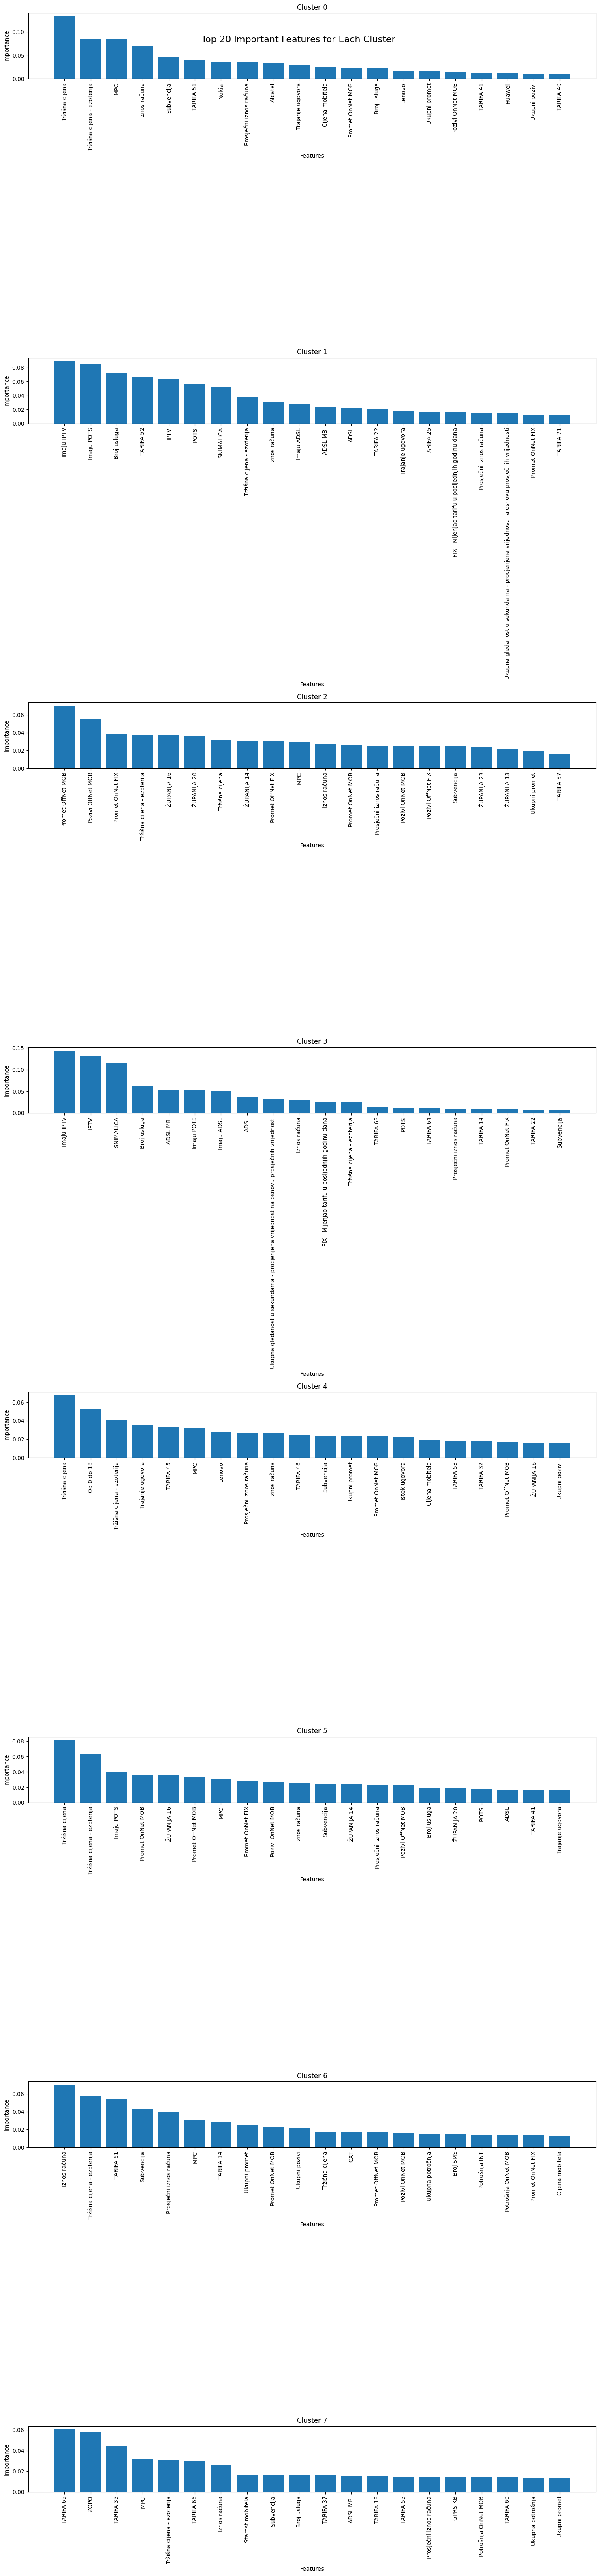

In [112]:
# Get unique clusters
unique_clusters = df_segment_description_rfc['Cluster'].unique()

# Set up the plot
n_clusters = len(unique_clusters)
fig, axs = plt.subplots(n_clusters, 1, figsize=(15, 8*n_clusters), squeeze=False)
fig.suptitle('Top 20 Important Features for Each Cluster', fontsize=16)

# Iterate through each cluster
for i, cluster in enumerate(unique_clusters):
    # Filter data for the current cluster
    cluster_data = df_segment_description_rfc[df_segment_description_rfc['Cluster'] == cluster]
    
    # Get top 20 features
    top_20_features = cluster_data.head(20)
    
    # Create the bar plot
    axs[i, 0].bar(top_20_features['Feature'], top_20_features['Importance'])
    axs[i, 0].set_title(f'{cluster}')
    axs[i, 0].set_xlabel('Features')
    axs[i, 0].set_ylabel('Importance')
    axs[i, 0].tick_params(axis='x', rotation=90)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# Assuming your data is in df_full and the cluster column is 'Segment'

# Prepare the data
X = df_full.drop('Segment', axis=1)
y = df_full['Segment']

# Iterate through each cluster
for cluster in sorted(y.unique()):
    print(f"\nProcessing Cluster {cluster}")
    
    # Create binary labels (1 for the current cluster, 0 for others)
    y_binary = (y == cluster).astype(int)
    
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.1, random_state=42)
    
    # Train Random Forest Classifier
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rfc.predict(X_test)
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for Cluster {cluster} vs Others: {accuracy:.4f}")
    
    # Calculate and print F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for Cluster {cluster} vs Others: {f1:.4f}")

    # Calculate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)



Processing Cluster 0
Accuracy for Cluster 0 vs Others: 0.9945
F1 Score for Cluster 0 vs Others: 0.9885
Confusion Matrix:
[[4551   26]
 [   7 1416]]

Processing Cluster 1
Accuracy for Cluster 1 vs Others: 0.9892
F1 Score for Cluster 1 vs Others: 0.9344
Confusion Matrix:
[[5472   22]
 [  43  463]]

Processing Cluster 2
Accuracy for Cluster 2 vs Others: 0.9782
F1 Score for Cluster 2 vs Others: 0.9247
Confusion Matrix:
[[5065   37]
 [  94  804]]

Processing Cluster 3
Accuracy for Cluster 3 vs Others: 0.9963
F1 Score for Cluster 3 vs Others: 0.9796
Confusion Matrix:
[[5450   14]
 [   8  528]]

Processing Cluster 4
Accuracy for Cluster 4 vs Others: 0.9892
F1 Score for Cluster 4 vs Others: 0.8105
Confusion Matrix:
[[5796    3]
 [  62  139]]

Processing Cluster 5
Accuracy for Cluster 5 vs Others: 0.9813
F1 Score for Cluster 5 vs Others: 0.9740
Confusion Matrix:
[[3793   62]
 [  50 2095]]

Processing Cluster 6
Accuracy for Cluster 6 vs Others: 0.9832
F1 Score for Cluster 6 vs Others: 0.6873
Co

### CUMMULATIVE IMPORTANCE (DEALING WITH CORRELATED FEATURES)

In [104]:
# Assuming your data is in df_full and the cluster column is 'Segment'

# Prepare the data
X = df_full.drop('Segment', axis=1)
y = df_full['Segment']

# Create a list to store the results
segment_description_rfc = []

# Iterate through each cluster
for cluster in y.unique():
    # Create binary labels (1 for the current cluster, 0 for others)
    y_binary = (y == cluster).astype(int)
    
    # Train Random Forest Classifier
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X, y_binary)
    
    # Get feature importances
    importances = rfc.feature_importances_
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Add all features to the list of results
    for _, row in feature_importance.iterrows():
        segment_description_rfc.append({
            'Cluster': f'Cluster {cluster}',
            'Feature': row['Feature'],
            'Importance': row['Importance']
        })

# Create DataFrame from the list of results
df_segment_description_rfc = pd.DataFrame(segment_description_rfc)

# Sort the DataFrame
df_segment_description_rfc = df_segment_description_rfc.sort_values(['Cluster', 'Importance'], ascending=[True, False])

# Create a new DataFrame for adjusted importances
df_adjusted_importance = df_segment_description_rfc.copy()

# Iterate through each cluster
for cluster in df_adjusted_importance['Cluster'].unique():
    # Get data for this cluster
    cluster_data = df_full[df_full['Segment'] == int(cluster.split()[-1])]
    
    # Calculate correlation matrix for this cluster
    correlation_matrix = cluster_data.drop('Segment', axis=1).corr().abs()
    
    cluster_importances = df_adjusted_importance[df_adjusted_importance['Cluster'] == cluster]
    
    # Iterate through each feature in the cluster
    for _, row in cluster_importances.iterrows():
        feature = row['Feature']
        correlated_features = correlation_matrix[feature][correlation_matrix[feature] >= 0.8].index.tolist()
        
        # Sum importances of correlated features
        additional_importance = cluster_importances[cluster_importances['Feature'].isin(correlated_features)]['Importance'].sum()
        
        # Update the importance in the new DataFrame
        df_adjusted_importance.loc[(df_adjusted_importance['Cluster'] == cluster) & 
                                   (df_adjusted_importance['Feature'] == feature), 'Importance'] += additional_importance

# Sort the adjusted DataFrame
df_adjusted_importance = df_adjusted_importance.sort_values(['Cluster', 'Importance'], ascending=[True, False])

# Remove features with importance less than 0.02
df_adjusted_importance = df_adjusted_importance[df_adjusted_importance['Importance'] >= 0.02]

In [79]:
# SCALING (OPTIONAL)

'''
# Calculate the sum of Importance for each Cluster
cluster_sums = df_adjusted_importance.groupby('Cluster')['Importance'].sum().reset_index()
cluster_sums = cluster_sums.rename(columns={'Importance': 'Total_Importance'})

# Merge the sums back to the original dataframe
df_adjusted_importance = df_adjusted_importance.merge(cluster_sums, on='Cluster', how='left')

# Calculate Normalized_Importance
df_adjusted_importance['Normalized_Importance'] = df_adjusted_importance['Importance'] / df_adjusted_importance['Total_Importance']

# Round the Normalized_Importance values to 4 decimal places
df_adjusted_importance['Normalized_Importance'] = df_adjusted_importance['Normalized_Importance'].round(4)

# Drop the Total_Importance column as it's no longer needed
df_adjusted_importance = df_adjusted_importance.drop('Total_Importance', axis=1)

# Sort the final DataFrame
df_adjusted_importance = df_adjusted_importance.sort_values(['Cluster', 'Normalized_Importance'], ascending=[True, False])
'''

In [105]:
# Initialize new columns
df_adjusted_importance['Mean'] = np.nan
df_adjusted_importance['Standard_Deviation'] = np.nan
df_adjusted_importance['Feature Mean'] = np.nan
df_adjusted_importance['90% Interval Lower'] = np.nan
df_adjusted_importance['90% Interval Upper'] = np.nan

# Iterate through each row in df_adjusted_importance
for idx, row in df_adjusted_importance.iterrows():
    cluster_num = int(row['Cluster'].split()[-1])  # Extract cluster number
    feature = row['Feature']
    
    # Calculate mean and std dev for the cluster
    cluster_data = df_full[df_full['Segment'] == cluster_num][feature]
    mean = cluster_data.mean()
    std_dev = cluster_data.std()
    
    # Calculate overall mean for the feature
    overall_mean = df_full[feature].mean()
    
    # Calculate 90% interval using quantiles
    lower = cluster_data.quantile(0.05)
    upper = cluster_data.quantile(0.95)
    
    # Assign values to new columns
    df_adjusted_importance['Importance'] = df_adjusted_importance['Importance'].round(3)
    df_adjusted_importance.at[idx, 'Mean'] = round(mean, 3)
    df_adjusted_importance.at[idx, 'Standard_Deviation'] = round(std_dev, 3)
    df_adjusted_importance.at[idx, 'Feature Mean'] = round(overall_mean, 3)
    df_adjusted_importance.at[idx, '90% Interval Lower'] = round(lower, 3)
    df_adjusted_importance.at[idx, '90% Interval Upper'] = round(upper, 3)

In [131]:
df_adjusted_importance.to_excel('segment_description_rfc_adjusted.xlsx', index=False)

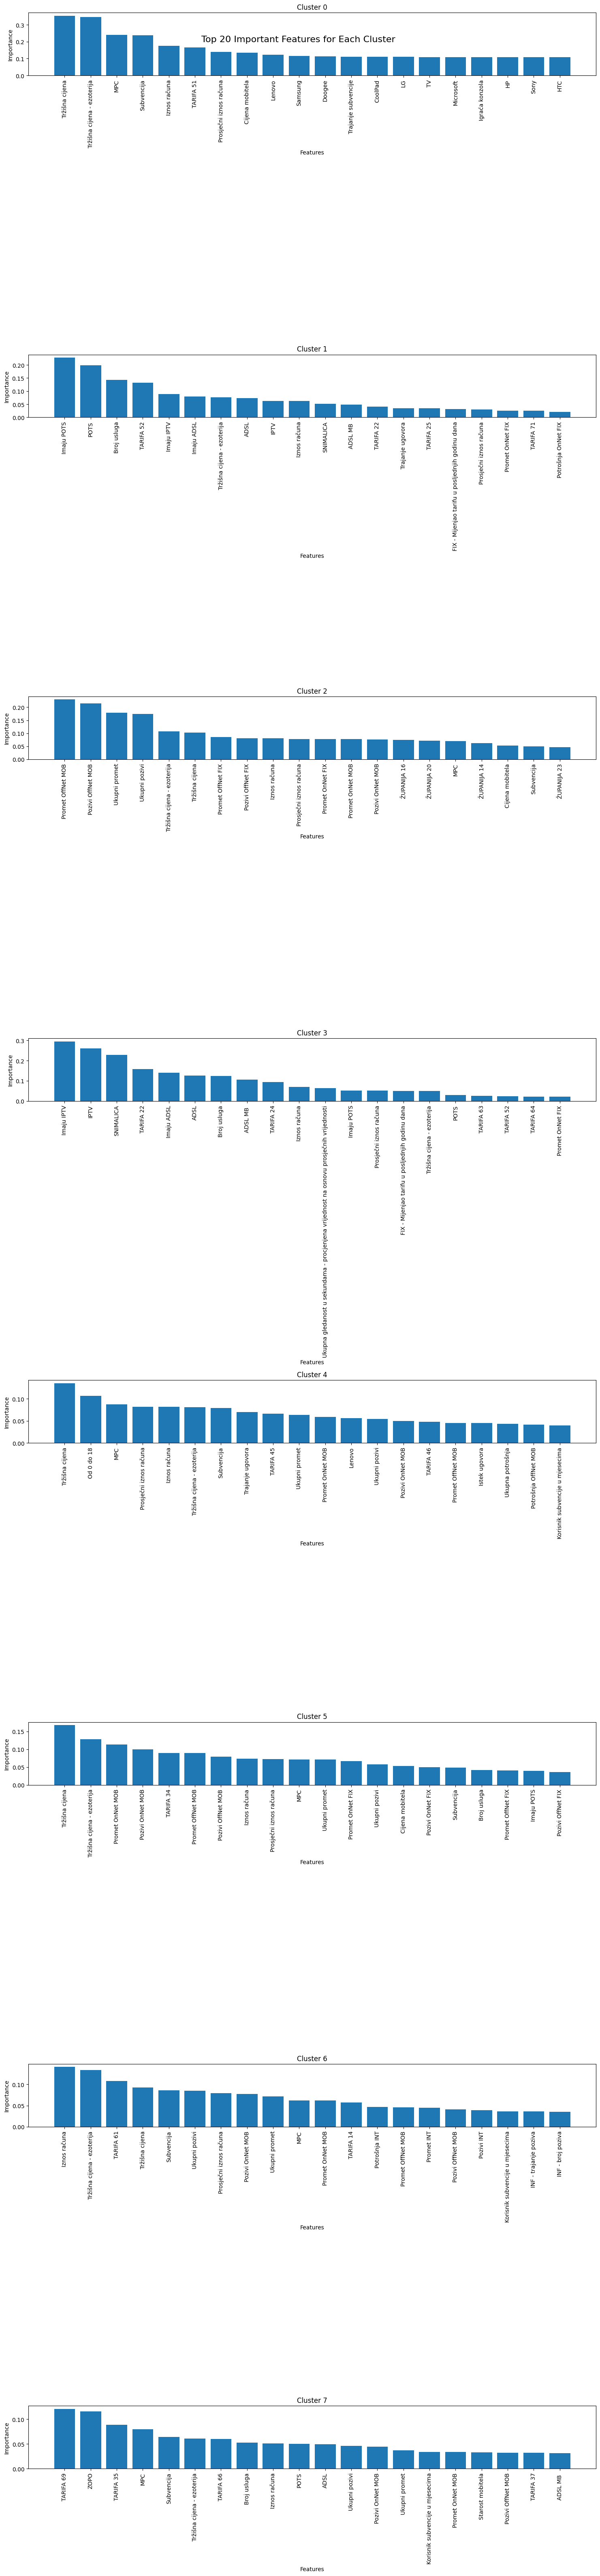

In [116]:
# Get unique clusters
unique_clusters = df_adjusted_importance['Cluster'].unique()

# Set up the plot
n_clusters = len(unique_clusters)
fig, axs = plt.subplots(n_clusters, 1, figsize=(15, 8*n_clusters), squeeze=False)
fig.suptitle('Top 20 Important Features for Each Cluster', fontsize=16)

# Iterate through each cluster
for i, cluster in enumerate(unique_clusters):
    # Filter data for the current cluster
    cluster_data = df_adjusted_importance[df_adjusted_importance['Cluster'] == cluster]
    
    # Get top 20 features
    top_20_features = cluster_data.head(20)
    
    # Create the bar plot
    axs[i, 0].bar(top_20_features['Feature'], top_20_features['Importance'])
    axs[i, 0].set_title(f'{cluster}')
    axs[i, 0].set_xlabel('Features')
    axs[i, 0].set_ylabel('Importance')
    axs[i, 0].tick_params(axis='x', rotation=90)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()

# Show the plot
plt.show()

In [78]:
cluster_counts = df_adjusted_importance['Cluster'].value_counts().sort_index()

for cluster, count in cluster_counts.items():
    print(f"{cluster}: {count} significant features")

Cluster 0: 44 significant features
Cluster 1: 20 significant features
Cluster 2: 35 significant features
Cluster 3: 20 significant features
Cluster 4: 34 significant features
Cluster 5: 30 significant features
Cluster 6: 43 significant features
Cluster 7: 45 significant features


I'll now create a final excel file which nicely showcases significant features for every cluster.

In [128]:
# Create a pivot table from df_segment_description_rfc
rfc_pivot = df_segment_description_rfc.pivot(index='Feature', columns='Cluster', values='Importance')

# Create pivot tables from df_adjusted_importance
adj_imp_pivot = df_adjusted_importance.pivot(index='Feature', columns='Cluster', values='Importance')
mean_pivot = df_adjusted_importance.pivot(index='Feature', columns='Cluster', values='Mean')
stddev_pivot = df_adjusted_importance.pivot(index='Feature', columns='Cluster', values='Standard_Deviation')

# Get all unique features and clusters
all_features = sorted(set(rfc_pivot.index) | set(adj_imp_pivot.index))
all_clusters = sorted(set(rfc_pivot.columns) | set(adj_imp_pivot.columns))

# Create the final matrix
df_final = pd.DataFrame(index=all_features, columns=all_clusters)

for feature in all_features:
    for cluster in all_clusters:
        try:
            mean = mean_pivot.loc[feature, cluster]
            stddev = stddev_pivot.loc[feature, cluster]
            rfc_imp = rfc_pivot.loc[feature, cluster]
            adj_imp = adj_imp_pivot.loc[feature, cluster]
            
            if pd.isna(mean) or pd.isna(stddev) or pd.isna(rfc_imp) or pd.isna(adj_imp):
                df_final.loc[feature, cluster] = ''
            else:
                df_final.loc[feature, cluster] = f"{mean:.3f} ± {stddev:.3f}, Imp: {rfc_imp:.3f}, Adj imp: {adj_imp:.3f}"
        except KeyError:
            df_final.loc[feature, cluster] = ''

# Save the final matrix to an Excel file
df_final.to_excel('segment_description_final.xlsx')

print("Matrix has been created and saved to 'segment_description_final.xlsx'")

Matrix has been created and saved to 'segment_description_final.xlsx'


## LDA


Analyzing Cluster 0


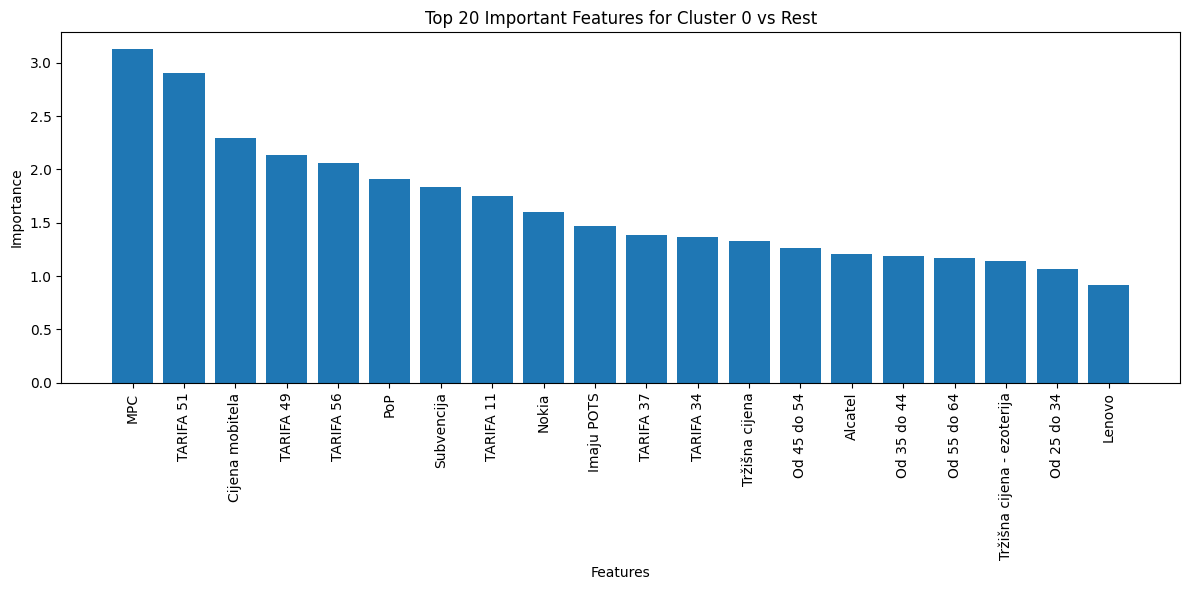


Analyzing Cluster 1


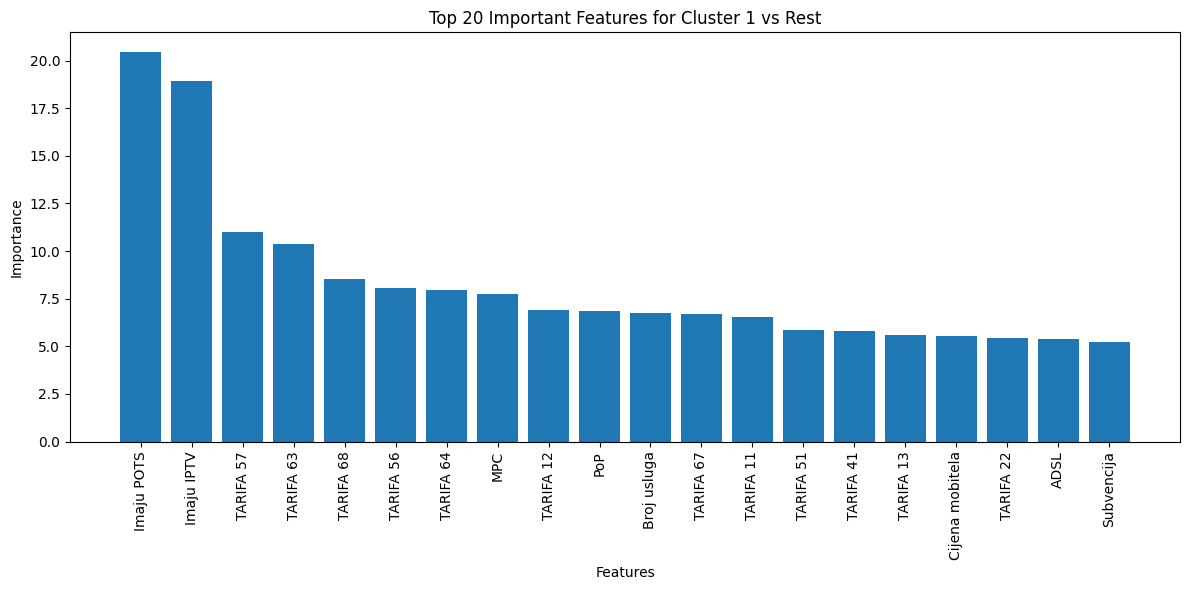


Analyzing Cluster 2


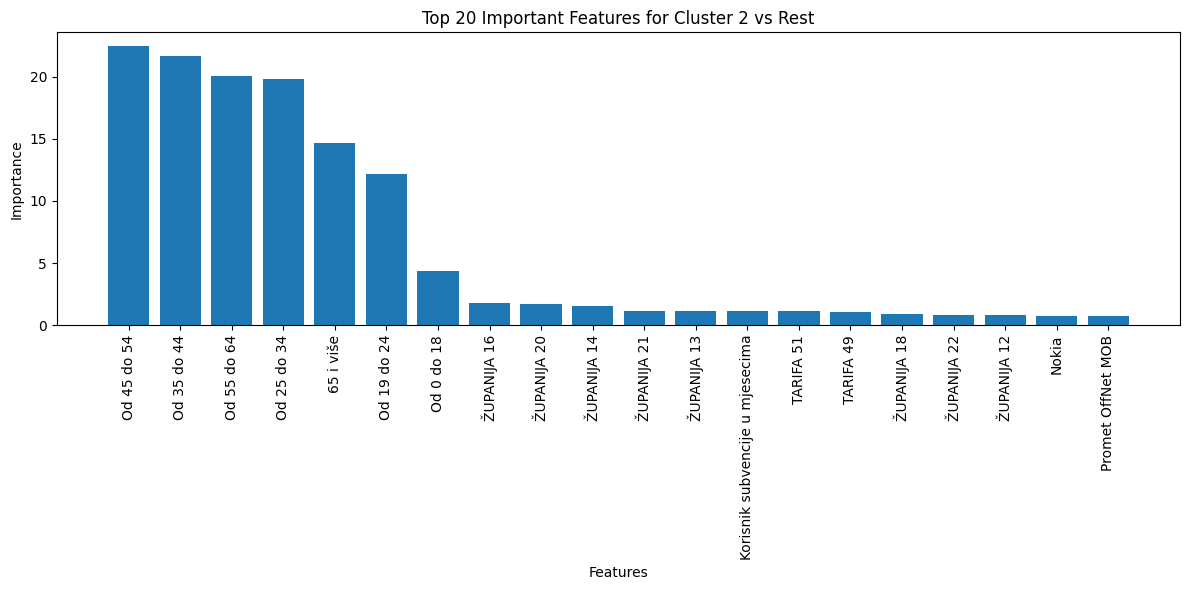


Analyzing Cluster 3


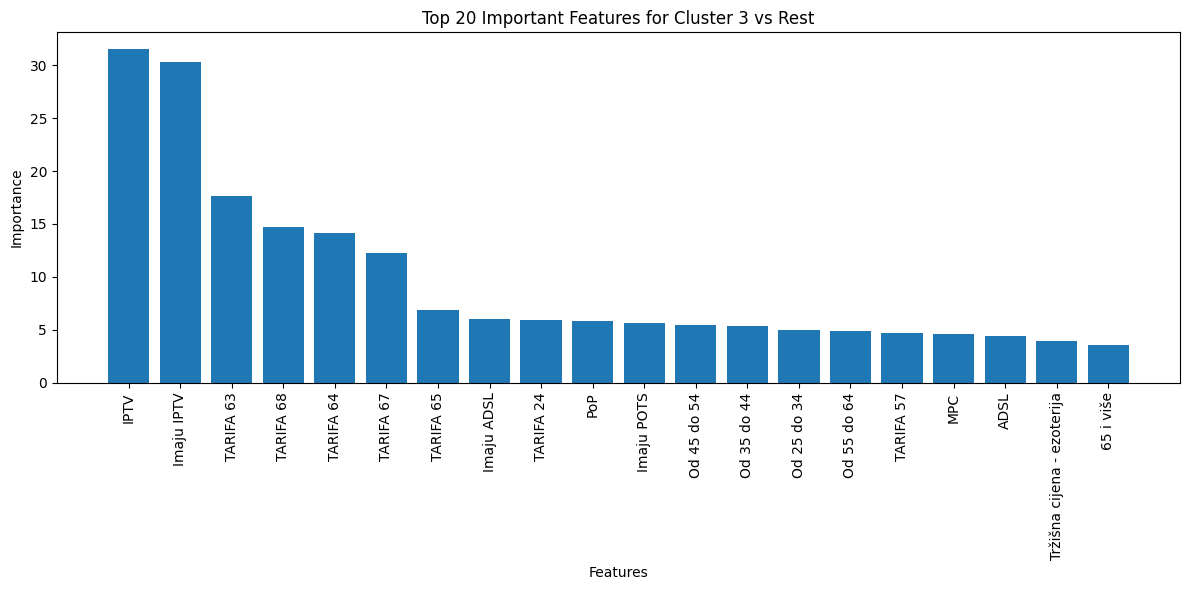


Analyzing Cluster 4


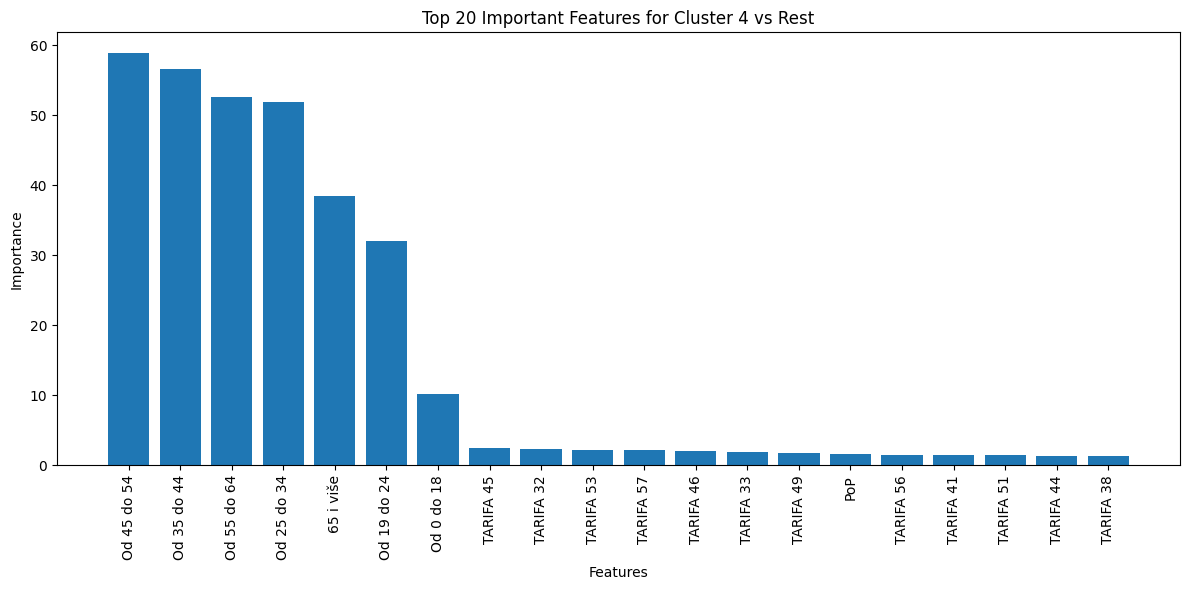


Analyzing Cluster 5


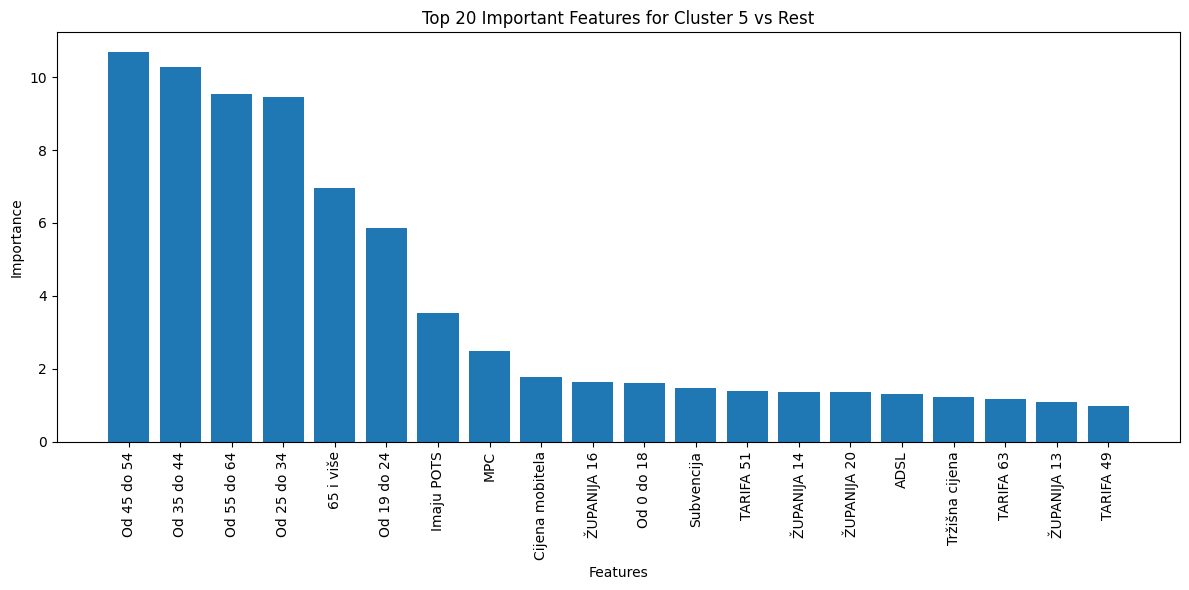


Analyzing Cluster 6


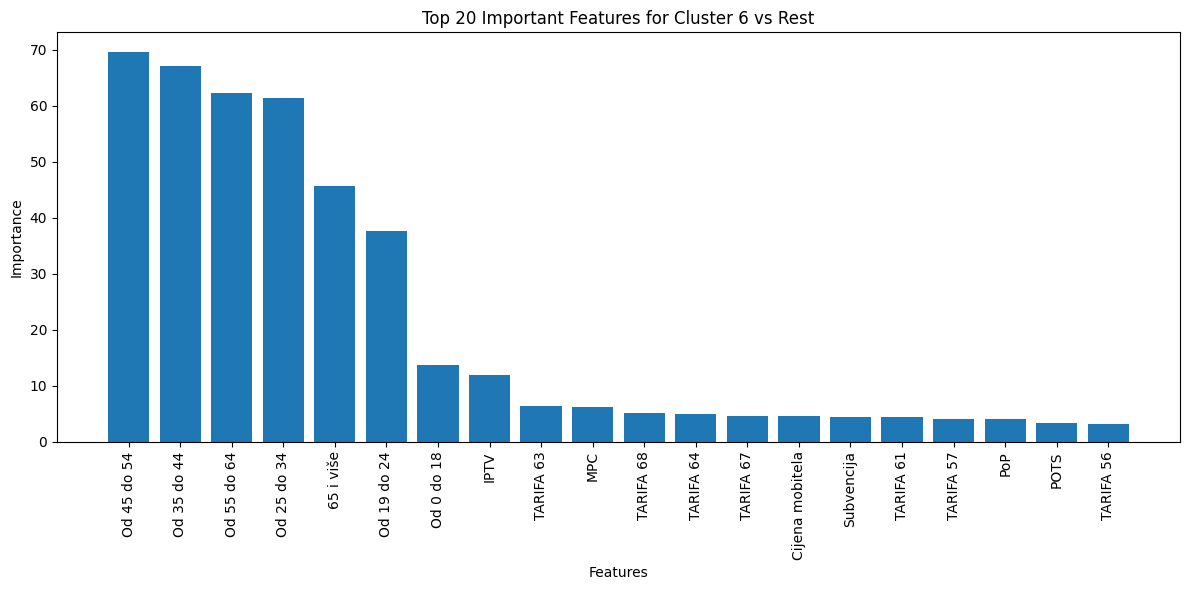


Analyzing Cluster 7


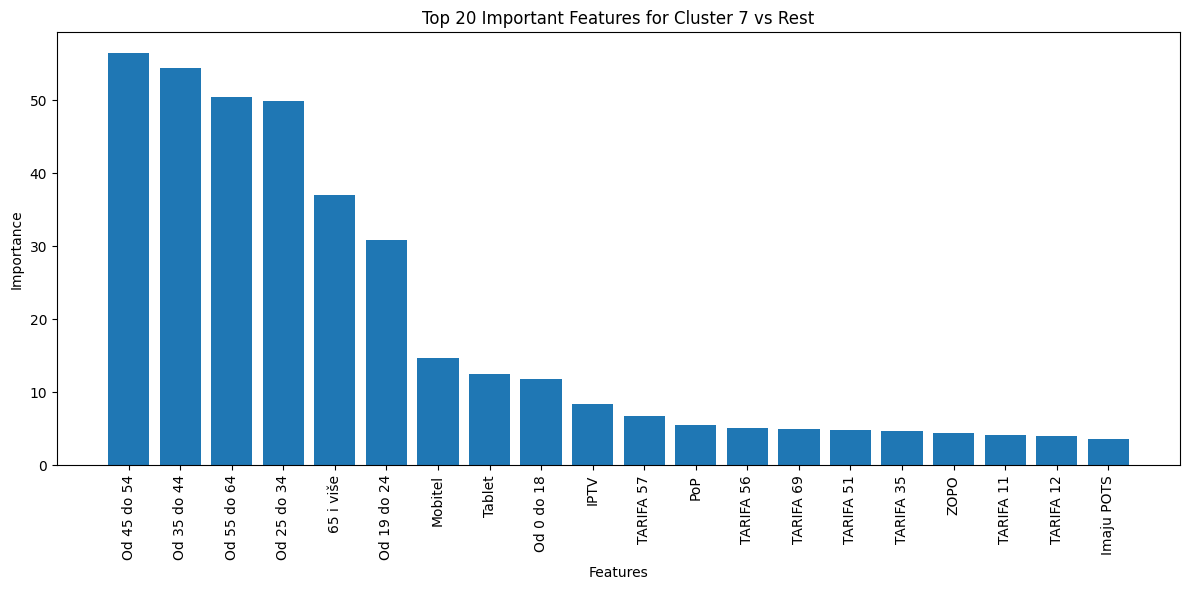

Results saved to segment_description_LDA.xlsx


In [110]:
# Function to get feature importance for a cluster
def get_feature_importance(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_scaled, y)
    
    feature_importance = np.abs(lda.coef_[0])
    
    return feature_importance

# Get the list of unique clusters
clusters = sorted(df_full['Segment'].unique())

# Initialize an empty list to store all results
all_results = []

# Loop through each cluster
for cluster in clusters:
    print(f"\nAnalyzing Cluster {cluster}")
    
    # Create binary classification: 1 for current cluster, 0 for others
    y = (df_full['Segment'] == cluster).astype(int)
    
    # Select features (all columns except 'Segment')
    X = df_full.drop('Segment', axis=1)
    
    # Get feature importance
    feature_importance = get_feature_importance(X, y)
    
    # Create a dataframe of feature importances
    feature_importance_df = pd.DataFrame({
        'Cluster': f'Cluster {cluster}',
        'Feature': X.columns,
        'Importance': feature_importance
    })
    
    # Calculate Mean, Standard Deviation, and Feature Mean
    for feature in X.columns:
        mean, std = get_mean_std(feature, cluster, df_full)
        feature_mean = get_overall_mean(feature, df_full)
        feature_importance_df.loc[feature_importance_df['Feature'] == feature, 'Mean'] = mean
        feature_importance_df.loc[feature_importance_df['Feature'] == feature, 'Standard Deviation'] = std
        feature_importance_df.loc[feature_importance_df['Feature'] == feature, 'Feature Mean'] = feature_mean
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Append to all_results
    all_results.append(feature_importance_df)

    # Get top 20 features for visualization
    top_20_features = feature_importance_df.head(20)

    # Visualize feature importance for top 20 features
    plt.figure(figsize=(12, 6))
    plt.bar(top_20_features['Feature'], top_20_features['Importance'])
    plt.xticks(rotation=90)
    plt.title(f'Top 20 Important Features for Cluster {cluster} vs Rest')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Combine all results into a single DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df = all_results_df.sort_values(['Cluster', 'Importance'], ascending=[True, False])

# Round numeric columns to 6 decimal places
numeric_columns = ['Importance', 'Mean', 'Standard Deviation', 'Feature Mean']
all_results_df[numeric_columns] = all_results_df[numeric_columns].round(6)

# Save to Excel
all_results_df.to_excel('segment_description_LDA.xlsx', index=False)

print("Results saved to segment_description_LDA.xlsx")

## XGB CLASSIFIER

In [35]:
# Assuming your data is in df_full, the cluster column is 'Segment', and significant_features_df contains the significant features for each cluster

# Prepare the data
X = df_full.drop('Segment', axis=1)
y = df_full['Segment']

# Create a list to store the results
results = []

# Iterate through each cluster
for cluster in y.unique():
    # Get significant features for this cluster
    significant_features = significant_features_df[
        (significant_features_df['Cluster'] == f'Cluster {cluster}')
    ]['Feature'].tolist()
    
    # If there are no significant features for this cluster, skip it
    if not significant_features:
        continue
    
    # Filter X to include only significant features for this cluster
    X_significant = X[significant_features]
    
    # Create binary labels (1 for the current cluster, 0 for others)
    y_binary = (y == cluster).astype(int)
    
    # Train XGBoost Classifier
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    xgb_model.fit(X_significant, y_binary)
    
    # Get feature importances
    importances = xgb_model.feature_importances_
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({'Feature': X_significant.columns, 'Importance': importances})
    
    # Filter features with importance >= 0.01
    important_features = feature_importance[feature_importance['Importance'] >= 0.01]
    
    # Sort features by importance
    important_features = important_features.sort_values('Importance', ascending=False)
    
    # Add selected features to the results list
    for _, row in important_features.iterrows():
        results.append({
            'Cluster': f'Cluster {cluster}',
            'Feature': row['Feature'],
            'Importance': row['Importance']
        })

# Create the final DataFrame from the results list
df_segment_description_xgb = pd.DataFrame(results)

# Sort the final DataFrame
df_segment_description_xgb = df_segment_description_xgb.sort_values(['Cluster', 'Importance'], ascending=[True, False])

In [36]:
# Initialize new columns
df_segment_description_xgb['Mean'] = np.nan
df_segment_description_xgb['Standard_Deviation'] = np.nan
df_segment_description_xgb['Feature Mean'] = np.nan

# Iterate through each row in df_segment_description_xgb
for idx, row in df_segment_description_xgb.iterrows():
    cluster_num = int(row['Cluster'].split()[-1])  # Extract cluster number
    feature = row['Feature']
    
    # Calculate mean and std dev for the cluster
    mean, std_dev = get_mean_std(feature, cluster_num, df_full)
    
    # Calculate overall mean for the feature
    overall_mean = get_overall_mean(feature, df_full)
    
    # Assign values to new columns
    df_segment_description_xgb.at[idx, 'Mean'] = round(mean, 3)
    df_segment_description_xgb.at[idx, 'Standard_Deviation'] = round(std_dev, 3)
    df_segment_description_xgb.at[idx, 'Feature Mean'] = round(overall_mean, 3)

In [38]:
df_segment_description_xgb.to_excel('segment_description_xgboost.xlsx', index=False)

In [39]:
# Prepare the data
X = df_full.drop('Segment', axis=1)
y = df_full['Segment']

# Iterate through each cluster
for cluster in sorted(y.unique()):
    print(f"\nProcessing Cluster {cluster}")
    
    # Create binary labels (1 for the current cluster, 0 for others)
    y_binary = (y == cluster).astype(int)
    
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.1, random_state=42)
    
    # Train XGBoost Classifier
    xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42)
    xgb_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xgb_clf.predict(X_test)
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for Cluster {cluster} vs Others: {accuracy:.4f}")
    
    # Calculate and print F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for Cluster {cluster} vs Others: {f1:.4f}")

    # Calculate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)


Processing Cluster 0
Accuracy for Cluster 0 vs Others: 0.9977
F1 Score for Cluster 0 vs Others: 0.9951
Confusion Matrix:
[[4570    7]
 [   7 1416]]

Processing Cluster 1
Accuracy for Cluster 1 vs Others: 0.9930
F1 Score for Cluster 1 vs Others: 0.9585
Confusion Matrix:
[[5473   21]
 [  21  485]]

Processing Cluster 2
Accuracy for Cluster 2 vs Others: 0.9912
F1 Score for Cluster 2 vs Others: 0.9704
Confusion Matrix:
[[5079   23]
 [  30  868]]

Processing Cluster 3
Accuracy for Cluster 3 vs Others: 0.9973
F1 Score for Cluster 3 vs Others: 0.9851
Confusion Matrix:
[[5454   10]
 [   6  530]]

Processing Cluster 4
Accuracy for Cluster 4 vs Others: 0.9963
F1 Score for Cluster 4 vs Others: 0.9439
Confusion Matrix:
[[5793    6]
 [  16  185]]

Processing Cluster 5
Accuracy for Cluster 5 vs Others: 0.9898
F1 Score for Cluster 5 vs Others: 0.9859
Confusion Matrix:
[[3814   41]
 [  20 2125]]

Processing Cluster 6
Accuracy for Cluster 6 vs Others: 0.9885
F1 Score for Cluster 6 vs Others: 0.8078
Co

# SUBSEGMENTATION

In [46]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Function to perform GMM subsegmentation
def gmm_subsegment(data, n_components=3, min_percentage=0.1, max_attempts=100):
    for attempt in range(max_attempts):
        gmm = GaussianMixture(n_components=n_components, random_state=attempt)
        subsegments = gmm.fit_predict(data)
        
        # Check if all subsegments have at least min_percentage of instances
        unique, counts = np.unique(subsegments, return_counts=True)
        percentages = counts / len(subsegments)
        
        if all(p >= min_percentage for p in percentages):
            return subsegments
    
    # If we couldn't find a good split after max_attempts, return the last attempt
    return subsegments

# Create a new column for subsegments in df_full
df_full['Subsegment'] = ''

# Get the unique cluster values from the second-to-last column of df_full
clusters = df_full.iloc[:, -2].unique()

# Iterate through each cluster
for cluster in clusters:
    # Get the data for the current cluster from df_pca
    cluster_mask = df_full.iloc[:, -2] == cluster
    cluster_data = df_pca[cluster_mask]
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Perform GMM subsegmentation
    subsegments = gmm_subsegment(scaled_data)
    
    # Create subsegment labels (e.g., "3.0", "3.1", "3.2" for cluster 3)
    subsegment_labels = [f"{cluster}.{sub}" for sub in subsegments]
    
    # Assign subsegment labels to the corresponding rows in df_full
    df_full.loc[cluster_mask, 'Subsegment'] = subsegment_labels

# Now df_full has a new 'Subsegment' column with the subsegment labels

In [47]:
df_full['Subsegment'].value_counts().sort_index()

0.0     2525
0.1     5719
0.2     6254
1.0      761
1.1     2703
1.2     1395
2.0     4327
2.1     2241
2.2     2277
3.0     1799
3.1     2433
3.2     1093
4.0     1086
4.1      451
4.2      388
5.0     3615
5.1    12688
5.2     5222
6.0      635
6.1      946
6.2      452
7.0      107
7.1      713
7.2      170
Name: Subsegment, dtype: int64